# Multiple Comparisons Correction

In [1]:
# First, import the necessary modules and functions
import os

import matplotlib.pyplot as plt
from myst_nb import glue
from nilearn import plotting

# Define where data files will be located
DATA_DIR = os.path.abspath("../data")
FIG_DIR = os.path.abspath("../images")

/home/data/nbc/misc-projects/Salo_NiMARE/nimare-paper/conda_env/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In NiMARE, multiple comparisons correction is separated from each CBMA and IBMA `Estimator`, so that any number of relevant correction methods can be applied after the `Estimator` has been fit to the `Dataset`.
Some correction options, such as the `montecarlo` option for FWE correction, are designed to work specifically with a given `Estimator` (and are indeed implemented within the `Estimator` class, and only called by the `Corrector`).

`Corrector`s are divided into two subclasses: `FWECorrector`s, which correct based on family-wise error rate, and `FDRCorrector`s, which correct based on false discovery rate.

All `Corrector`s are initialized with a number of parameters, including the correction method that will be used.
After that, you can use the `transform` method on a `MetaResult` object produced by a CBMA or IBMA `Estimator` to apply the correction method.
This will return an updated `MetaResult` object, with both the statistical maps from the original `MetaResult`, as well as new, corrected maps.

Here we will apply both FWE and FDR correction to results from a MKDADensity meta-analysis, performed back in [](content:cbma:mkdad).

In [2]:
from nimare import meta, correct

mkdad_meta = meta.cbma.mkda.MKDADensity.load(os.path.join(DATA_DIR, "MKDADensity.pkl.gz"))

mc_corrector = correct.FWECorrector(method="montecarlo", n_iters=10000, n_cores=4)
mc_results = mc_corrector.transform(mkdad_meta.results)
mc_results.save_maps(output_dir=DATA_DIR, prefix="MKDADensity_FWE")

fdr_corrector = correct.FDRCorrector(method="indep")
fdr_results = fdr_corrector.transform(mkdad_meta.results)

INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.mkda.MKDADensity.correct_fwe_montecarlo.


  0%|          | 0/10000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


Statistical maps saved by NiMARE `MetaResult`s automatically follow a naming convention based loosely on the Brain Imaging Data Standard (BIDS).

Let's take a look at the files created by the `FWECorrector`.

In [3]:
from glob import glob

fwe_maps = sorted(glob(os.path.join(DATA_DIR, "MKDADensity_FWE*.nii.gz")))
fwe_maps = [os.path.basename(fwe_map) for fwe_map in fwe_maps]
print("\n".join(fwe_maps))

MKDADensity_FWE_logp_level-cluster_corr-FWE_method-montecarlo.nii.gz
MKDADensity_FWE_logp_level-voxel_corr-FWE_method-montecarlo.nii.gz
MKDADensity_FWE_p.nii.gz
MKDADensity_FWE_stat.nii.gz
MKDADensity_FWE_z.nii.gz
MKDADensity_FWE_z_level-cluster_corr-FWE_method-montecarlo.nii.gz
MKDADensity_FWE_z_level-voxel_corr-FWE_method-montecarlo.nii.gz


If you ignore the prefix, which was specified in the call to `MetaResult.save_maps`, the maps all have a common naming convention.
The maps from the original meta-analysis (before multiple comparisons correction) are simply named according to the values contained in the map (e.g., `z`, `stat`, `p`).

Maps generated by the correction method, however, use a series of key-value pairs to indicate how they were generated.
The `corr` key indicates whether FWE or FDR correction was applied.
The `method` key reflects the correction method employed, which was defined by the `method` parameter used to create the `Corrector`.
The `level` key simply indicates if the map was corrected at the voxel or cluster level.
Finally, the `desc` key reflects any necessary description that goes beyond what is already covered by the other entities.

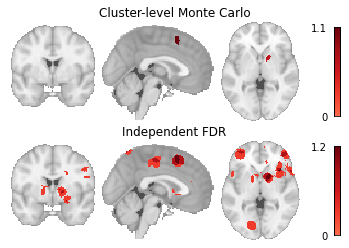

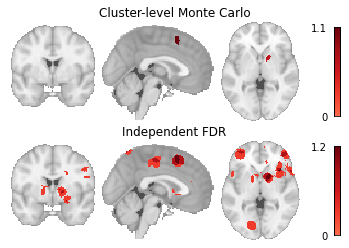

In [4]:
meta_results = {
    "Cluster-level Monte Carlo": mc_results.get_map(
        "z_level-cluster_corr-FWE_method-montecarlo",
        return_type="image",
    ),
    "Independent FDR": fdr_results.get_map(
        "z_corr-FDR_method-indep",
        return_type="image",
    ),
}

fig, axes = plt.subplots(figsize=(6, 4), nrows=2)

for i_meta, (name, file_) in enumerate(meta_results.items()):
    display = plotting.plot_stat_map(
        file_,
        annotate=False,
        axes=axes[i_meta],
        draw_cross=False,
        cmap="Reds",
        cut_coords=[0, 0, 0],
        figure=fig,
    )
    axes[i_meta].set_title(name)

    colorbar = display._cbar
    colorbar_ticks = colorbar.get_ticks()
    if colorbar_ticks[0] < 0:
        new_ticks = [colorbar_ticks[0], 0, colorbar_ticks[-1]]
    else:
        new_ticks = [colorbar_ticks[0], colorbar_ticks[-1]]
    colorbar.set_ticks(new_ticks, update_ticks=True)

glue("figure_corr_cbma", fig, display=False)

```{glue:figure} figure_corr_cbma
:name: figure_corr_cbma
:align: center

An array of plots of the corrected statistical maps produced by the different multiple comparisons correction methods.
```